## LFP Analysis

In [ ]:
# Imports and setup
from __future__ import annotations

import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.fftpack import fft
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, coherence
from fooof import FOOOF

from spk2extract.logs import logger
from spk2extract.spk_io import spk_h5

# Setup functions, classes and styles
logger.setLevel("INFO")
sns.set_style("darkgrid")

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    # Break down into two steps: first high-pass, then low-pass
    b, a = butter(order, lowcut / (0.5 * fs), btype="high")
    data = filtfilt(b, a, data)
    b, a = butter(order, highcut / (0.5 * fs), btype="low")
    y = filtfilt(b, a, data)
    return y

def get_data(path: Path | str):
    path = Path(path)
    files = list(path.glob("*dk3*"))
    file = files[0]
    h5_file = spk_h5.read_h5(path / file)
    spikes_df = pd.DataFrame()
    times_df = pd.DataFrame()
    events_arr = h5_file["events"]["events"]
    spikedata = h5_file["spikedata"]
    for chan, data in spikedata.items():
        if chan in ["VERSION", "CLASS", "TITLE"]:
            continue
        logger.info(f"Channel: {chan}")
        spikes = data["spikes"]
        times = data["times"]
        spikes_df[chan] = spikes
        times_df[chan] = times
    return spikes_df, times_df, events_arr

class LfpSignal:
    def __init__(self, spikes_df, times_df, fs, event_arr=None):
        self.spikes: pd.DataFrame = spikes_df
        self.times: pd.DataFrame = times_df
        self.events: np.ndarray | None = event_arr
        self.fs: float = fs
        self._bandpass: tuple = ()
        self.filtered: bool = False
        self.analysis_results: dict = {}

    @property
    def bandpass(self):
        return self._bandpass

    @bandpass.setter
    def bandpass(self, bandpass: tuple):
        assert len(bandpass) == 2, "Bandpass must be a tuple of length 2"
        self._bandpass = bandpass

    def filter(self):
        if not self._bandpass:
            logger.debug("Bandpass not set, skipping filtering")
            return
        low, high = self._bandpass
        self.spikes = self.spikes.apply(
            lambda col: butter_bandpass_filter(col, low, high, self.fs, order=4)
        )
        self.filtered = True

    def get_fft_values(self, signal):
        if hasattr(signal, "values"):
            signal = signal.values  # pd object isn't compatible with fft
        # signal = signal - np.mean(signal)  # remove DC component
        N = len(signal)
        fft_values = fft(signal)
        frequencies = np.fft.fftfreq(N, 1 / self.fs)
        return frequencies[: N // 2], 2.0 / N * np.abs(fft_values[: N // 2])

    def get_coherence(self, signal1, signal2):
        f, Cxy = coherence(signal1, signal2, fs=self.fs)
        return f, Cxy

    def get_band_power(self, signal, band):
        if hasattr(signal, "values"):
            signal = signal.values  # Convert to NumPy array if it's a Pandas Series
        freqs, fft_vals = self.get_fft_values(signal)
        band_freqs = [freq for freq in freqs if band[0] <= freq <= band[1]]
        band_fft_vals = [
            fft_val
            for fft_val, freq in zip(fft_vals, freqs)
            if band[0] <= freq <= band[1]
        ]
        return simps(band_fft_vals, band_freqs)

    def calculate_band_powers(self, bands):
        for channel in self.spikes.columns:
            self.analysis_results[channel] = {}
            for band_name, freq_range in bands.items():
                self.analysis_results[channel][band_name] = self.get_band_power(
                    self.spikes[channel], freq_range
                )

    def plot_coherence_for_pairs(self):
        channel_pairs = itertools.combinations(self.spikes.columns, 2)
        for chan1, chan2 in channel_pairs:
            f, Cxy = self.get_coherence(self.spikes[chan1], self.spikes[chan2])
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            ax.plot(f, Cxy)
            ax.set_title(f"Coherence between {chan1} and {chan2}")
            ax.set_xlabel("Frequency (Hz)")
            ax.set_ylabel("Coherence")
            ax.grid(True)
        plt.show()

# Load in data and create LFP class-object
data_path = Path().home() / "data" / "extracted"
df_s, df_t, events = get_data(data_path)
lfp = LfpSignal(df_s, df_t, event_arr=events, fs=2000)
lfp.bandpass = (0.1, 500)  # set a bandpass filter
fs = lfp.fs

## Plot the Data
1) Plot the first 4 seconds of the LFP data for each channel
2) Plot a 1 second window around each event
3) Plot the coherence between each pair of channels

In [ ]:
# Plot each channel ------------------------

num_channels = len(lfp.spikes.columns)
fig, axes = plt.subplots(num_channels, 1, figsize=(50, 40), sharex=True)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
first_4_seconds = int(4 * fs)
ticks = [0, int(1.0 * fs), int(2.0 * fs), int(3.0 * fs), int(4.0 * fs)]
labels = ['0', '1000', '2000', '3000', '4000']

for i, channel in enumerate(lfp.spikes.columns):
    ax = axes[i]
    ax.plot(lfp.spikes[channel][:first_4_seconds])
    ax.set_ylabel("Voltage (uV)")
    ax.set_title(channel)
    ax.grid(True)

In [ ]:
# Plot a 1 second window around each event ------------------------

new_ev = lfp.events[np.where(np.diff(lfp.events) > 2)[0]]
times = np.array(lfp.times["LFP1_AON"])
spikes = np.array(lfp.spikes["LFP1_AON"])
indices = np.rint(new_ev * fs).astype(int)
# Extract spike windows around these times
windows = []
for idx in indices:
    center_time = times[idx]
    
    # Calculate window start and end indices
    start_idx = max(idx - int(0 * fs), 0)
    end_idx = min(idx + int(1.0 * fs), len(spikes) - 1)
    
    # Extract spike window
    spike_window = spikes[start_idx:end_idx + 1]
    windows.append(spike_window)

n_pairs = len(windows) // 2
fig, axes = plt.subplots(n_pairs, 2, figsize=(20, 60), sharex=True)
x_ticks = [0, int(1.0 * fs)]
x_labels = ['0', '1000']

for i in range(n_pairs):
    ax1, ax2 = axes[i]
    ax1.plot(windows[2*i])
    ax2.plot(windows[2*i + 1])
    
    # Set the x-ticks and labels for each subplot
    for ax in [ax1, ax2]:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        
    ax1.set_xlim(0, len(windows[0]))
    ax2.set_xlim(0, len(windows[0]))
    ax1.set_ylabel("Voltage (uV)")
    ax2.set_ylabel("Voltage (uV)")
    ax1.set_xlabel("Time (ms)")
    ax2.set_xlabel("Time (ms)")
    ax1.grid(True)
    ax2.grid(True)
plt.show()

In [ ]:
bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 100),
}

lfp.calculate_band_powers(bands)
logger.info(lfp.analysis_results)

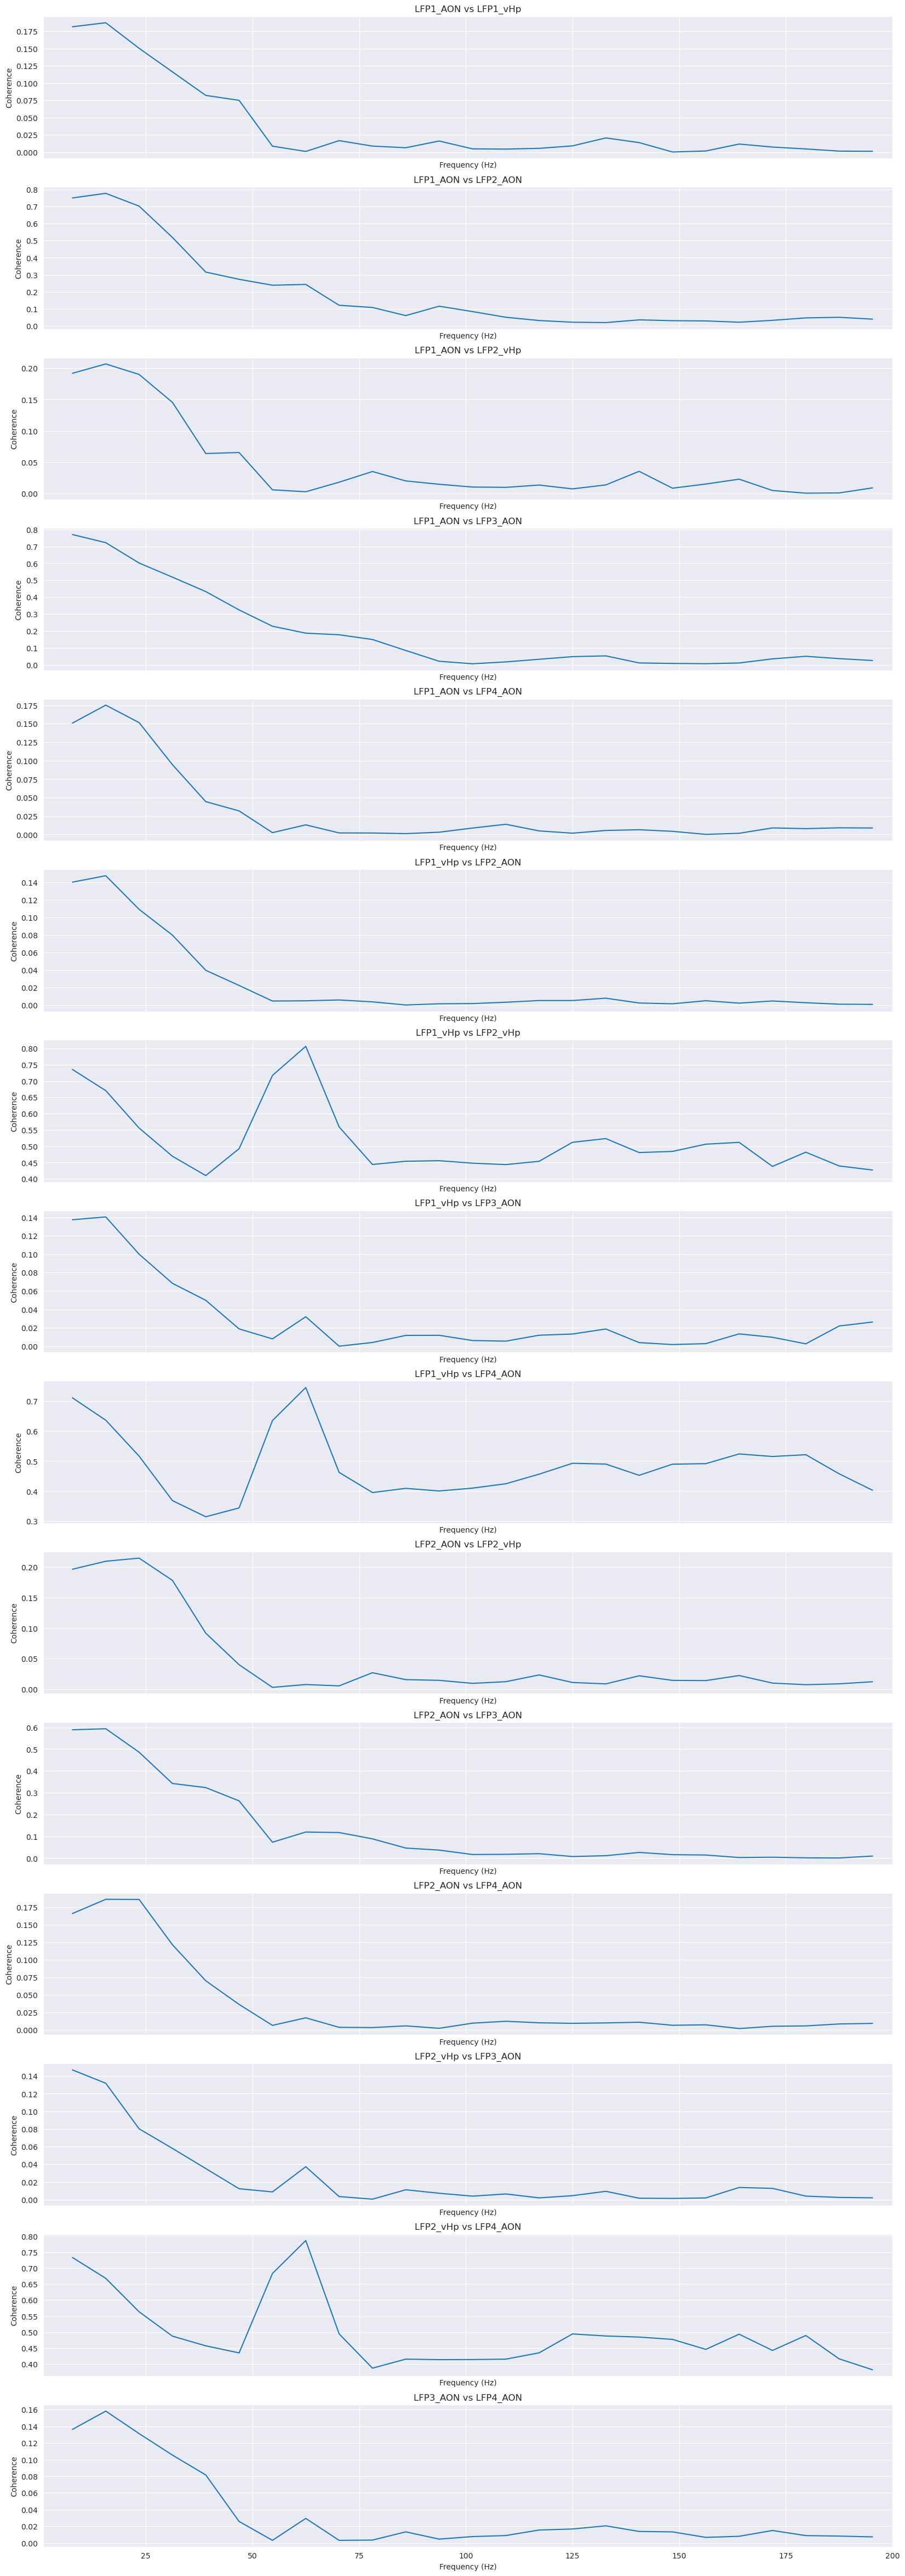

In [29]:
channel_pairs = list(itertools.combinations(lfp.spikes.columns, 2))
num_chan_pairs = len(channel_pairs)
fig, axes = plt.subplots(num_chan_pairs, 1, figsize=(20, 60), sharex=True)
plt.subplots_adjust(hspace=0.2)

for i, (chan1, chan2) in enumerate(channel_pairs):
    ax = axes[i]
    f, Cxy = lfp.get_coherence(lfp.spikes[chan1], lfp.spikes[chan2])

    # Limit frequencies to between 1 and 200
    mask = (f >= 1) & (f <= 200)
    f = f[mask]
    Cxy = Cxy[mask]

    ax.plot(f, Cxy)
    ax.set_title(f"{chan1} vs {chan2}")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Coherence")
    ax.set_xlim(1, 200)
    ax.grid(True)

plt.show()

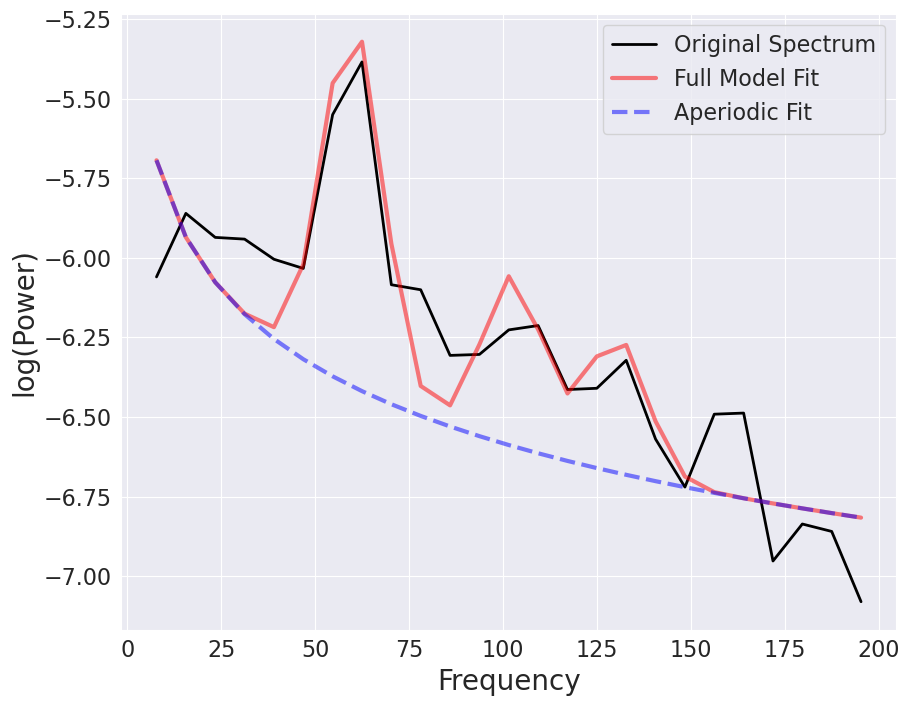

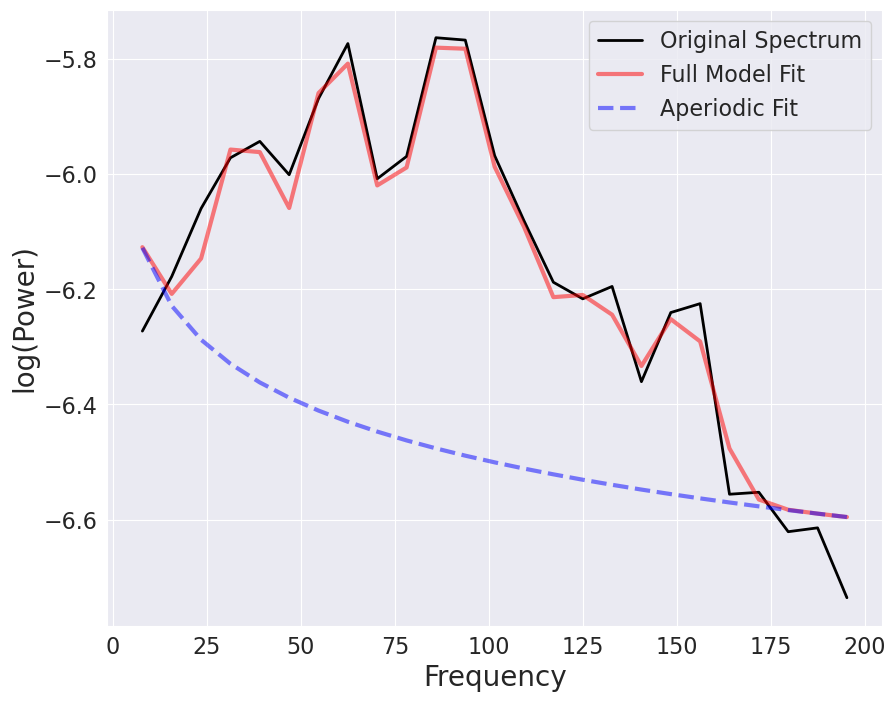

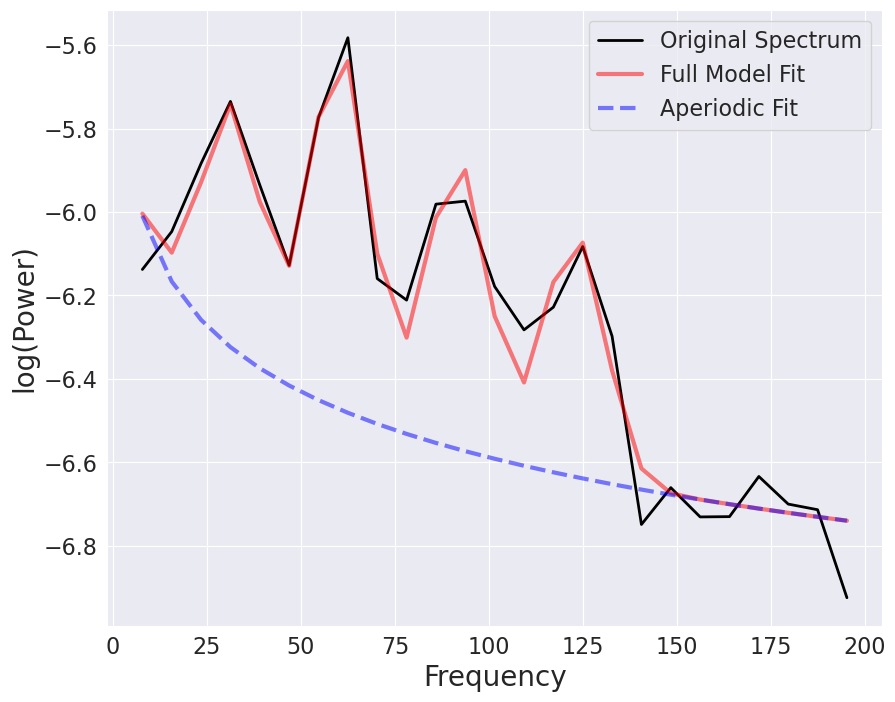

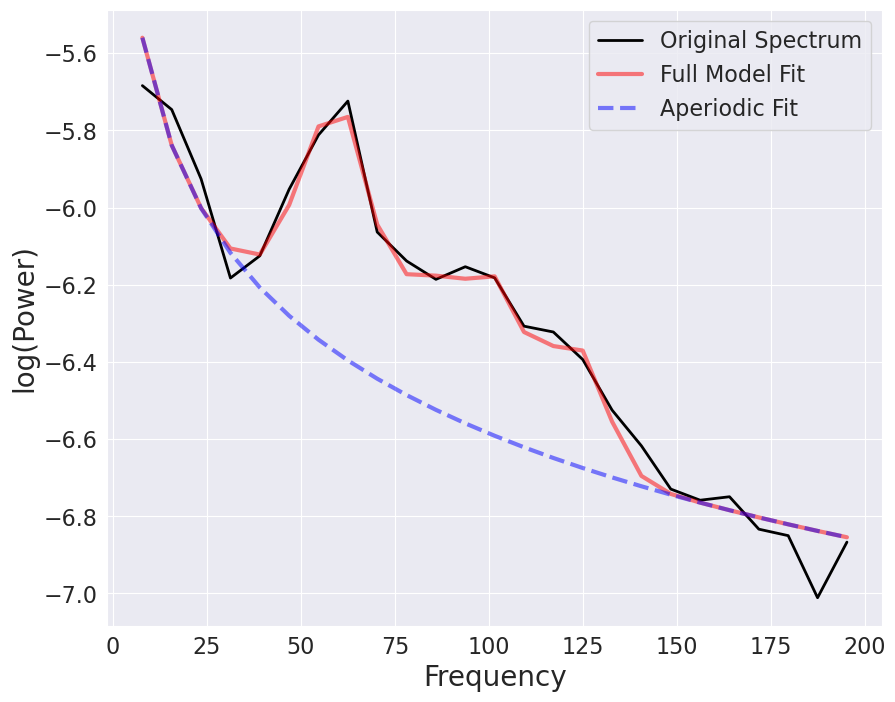

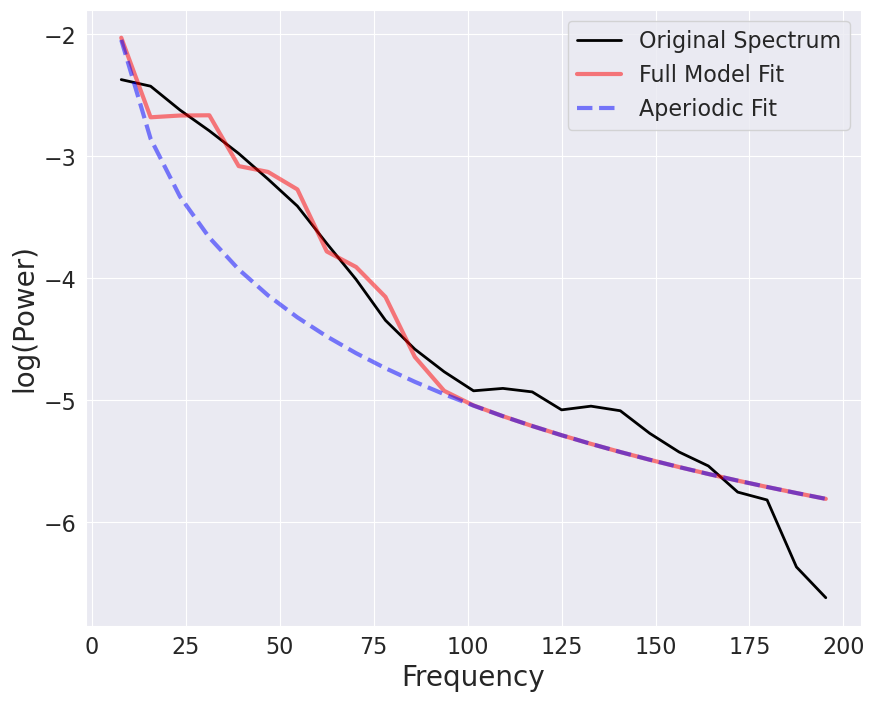

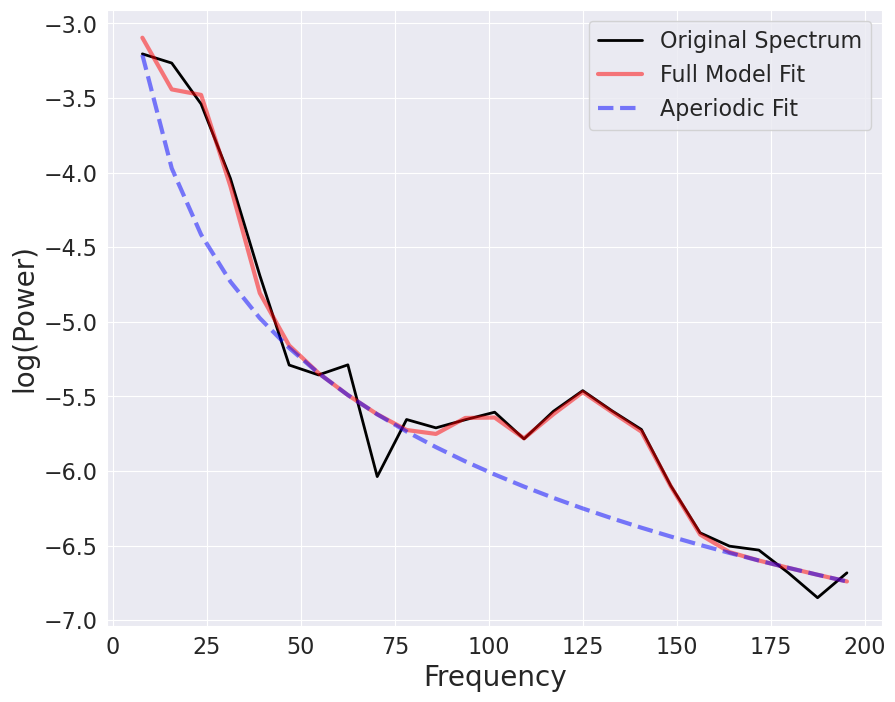

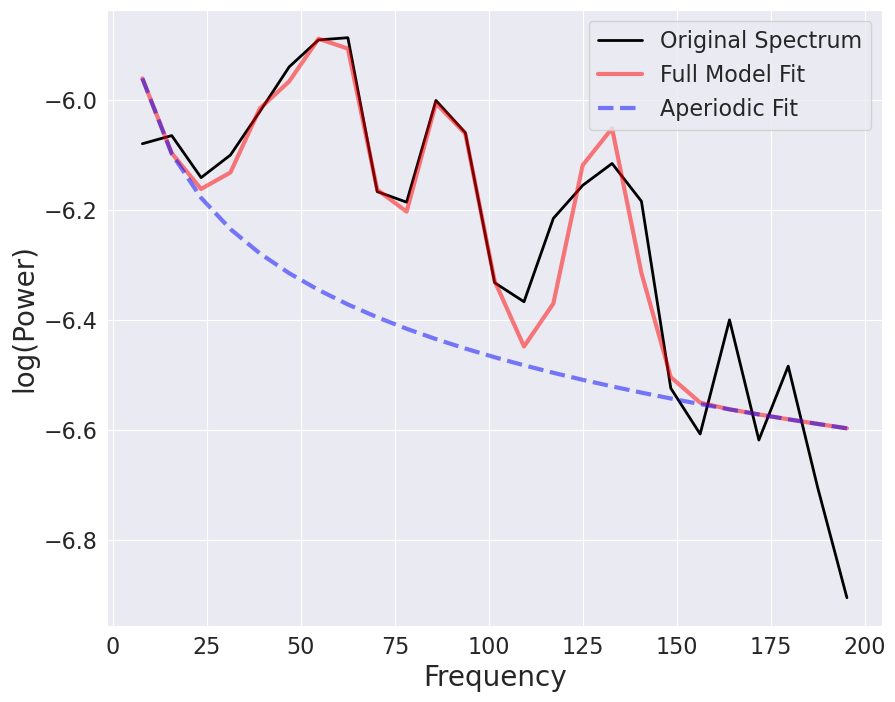

In [30]:
import random
import string
# Power spectrums
from scipy.signal import welch

freq_windows = windows[:7]
# Initialize a dictionary to hold FOOOF models for each channel
fooof_models = {}

for wind in freq_windows:
    random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    lfp_signal = wind
    
    # Compute the Power Spectral Density (PSD)
    frequencies, psd_values = welch(lfp_signal, fs=lfp.fs)
    
    # Slice frequencies and PSD values for 1-50Hz
    idx_start = np.where(frequencies >= 1)[0][0]
    idx_end = np.where(frequencies <= 200)[0][-1]
    frequencies = frequencies[idx_start:idx_end+1]
    psd_values = psd_values[idx_start:idx_end+1]

    # Calculate peak width limits
    peak_width_limits = [2 * (frequencies[1] - frequencies[0]), 16]  # Increased upper limit
    
    # Initialize FOOOF model
    fm = FOOOF(peak_width_limits=peak_width_limits)
    
    # Fit FOOOF model
    fm.fit(frequencies, psd_values)
    fooof_models[random_string] = fm
    
    # Plot
    fm.plot()

